# Season A Priori Flag Summary

**Steven Murray & Josh Dillon**, Last Revised May 2023

This notebook shows very simple summaries of the season in terms of observed antennas, times and frequencies, with flags. These are derived from the "scouting" flagger, which only looks at autocorrelations, `full_day_auto_checker.ipynb` in `hera_notebook_templates`. As such, it represents a minimal set of flags, but likely other failure modes that only appear in cross-correlations will be caught further down the pipeline. The main purpose of this investigation is to figure out which (subsets of which) JDs are worth analyzing.

Quick links to figures and tables:

## [• Figure 1: Unflagged JDs and LSTs](#Figure-1:-Unflagged-JDs-and-LSTs)
## [• Figure 2: LST-Coverage](#Figure-2:-LST-Coverage)
## [• Figure 3: Number of (Un)Flagged Antennas Per Night](#Figure-3:-Number-of-%28Un%29Flagged-Antennas-Per-Night)
## [• Figure 4: Number of (Un)Flagged Antenna Hours Per Night](#Figure-4:-Number-of-%28Un%29Flagged-Antenna-Hours-Per-Night)
## [• Figure 5: Number of (Un)Flagged Antenna Hour Channels Per Night](#Figure-5:-Number-of-%28Un%29Flagged-Antenna-Hour-Channels-Per-Night)
## [• Figure 6: Completely Flagged Channels By Night](#Figure-6:-Completely-Flagged-Channels-By-Night)
## [• Table 1: Per-Night Scouting Summary](#Table-1:-Per-Night-Scouting-Summary)
## [• Table 2: Bottom-Line Summary](#Table-2:-Bottom-Line-Summary)

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 1000)
import matplotlib.pyplot as plt
import matplotlib
import glob
import re
import os
from pathlib import Path
from astropy.time import Time
from IPython.display import display, HTML
from hera_notebook_templates.utils import status_colors, Antenna
import yaml
from astropy import units as u
from astropy.coordinates import EarthLocation
from pyuvdata import telescopes
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
display(HTML("<style>.container { width:100% !important; }</style>"))

## A Note on A Priori Flagging

The original YAML files were produced by "lightning scouting" with `full_day_auto_checker.ipynb` are in `/lustre/aoc/projects/hera/h6c-analysis/day_flags/0/`. However, manual inspection by JSD of all 177 notebooks (specifically Figures 2 and 3) resulted several changes, which are reflected [`hera_pipelines`](https://github.com/HERA-Team/hera_pipelines/tree/main/pipelines/h6c/analysis/apriori_flags). The original flags are still in the YAMLs there, but commented out. Changes fell into the following categories:

* RFI only briefly sends the metric for "too much broadband RFI" over threshold in the middle of the day, so it was decided to try to let `full_day_rfi.ipynb` try to handle it without a priori flags to avoid losing nearly half a day.
    * 2459892
    * 2459928

* The whole day was near threshold, but just under, so we're manually flagging the whole day
    * 2459911

* JD flags were seemed more consistent with a DPSS filtering artifact than real broadband RFI (due to missing data or other flags), and so were scaled back or removed.
    * 2459848
    * 2459849    
    * 2459856
    * 2459878
    * 2459881
    * 2459882    
    * 2459883
    * 2459893
    * 2459894
    * 2459910
    * 2459941
    * 2459991

* Flags seemed more consistent with a DPSS filtering artifact, but most of the array was dead anyway so we just flagged the whole day.
    * 2459999

It may be that further modifications to a priori flags are necessary after running the full analysis pipeline and inspecting notebooks. We'll cross that bridge when we come to it.

In [2]:
# Where to find the a priori YAML files
yaml_folder = Path('/lustre/aoc/projects/hera/h6c-analysis/IDR2/src/hera_pipelines/pipelines/h6c/analysis/apriori_flags')

In [3]:
# load yamls in chronological order
yamls = sorted(yaml_folder.glob('*apriori_flags.yaml'))
print(f'Found {len(yamls)} a-priori YAMLS in {yaml_folder}')

Found 177 a-priori YAMLS in /lustre/aoc/projects/hera/h6c-analysis/IDR2/src/hera_pipelines/pipelines/h6c/analysis/apriori_flags


## Load Data

In [4]:
data = {}
for y in yamls:
    int_jd = int(y.name[y.name.index("24"):y.name.index("24")+7])
    with open(y, 'r') as fl:
        data[int_jd] = yaml.load(fl, Loader=yaml.SafeLoader)

## Time-Based Flags

In [5]:
# Calculate the total amount of time that is flagged
hours_flagged = 0
hours_observed = 0
for jd, d in data.items():
    hours_observed += (d['jd_range'][1] - d['jd_range'][0])*24
    for flg in d['JD_flags']:
        hours_flagged += (flg[1] - flg[0])*24

In [6]:
hours_flagged_frac = hours_flagged / (hours_observed)

In [7]:
print(f"Total number of hours observed: {hours_observed:.2f}")
print(f"Total number of hours flagged: {hours_flagged:.2f}")
print(f"Unflagged hours observed: {hours_observed - hours_flagged:.2f}")
print(f"Percentage of hours flagged: { hours_flagged_frac * 100:.2f}%")

Total number of hours observed: 1716.37
Total number of hours flagged: 400.86
Unflagged hours observed: 1315.50
Percentage of hours flagged: 23.36%


In [8]:
dt = 9.663677215576172 # seconds

In [9]:
lsts = np.arange(0, 24, dt / 60 / 60 * u.day.in_units(u.sday))
location = EarthLocation(*(telescopes.get_telescope('HERA').telescope_location * u.m))

In [10]:
lst_flags = {}
for jd, d in data.items():
    jdmin, jdmax = d['jd_range']
    tmin = Time(jdmin, format='jd', scale='utc', location=location)
    tmax = Time(jdmax, format='jd', scale='utc', location=location)
    
    lstmin = tmin.sidereal_time("apparent").hour
    lstmax = tmax.sidereal_time("apparent").hour
    
    if lstmax < lstmin:
        lstmax += 24

    thislst = np.where(lsts<lstmin, lsts + 24, lsts)
    flags = thislst > lstmax
    if np.all(flags):
        print(jd, lstmin, lstmax)
    for flgrange in d['JD_flags']:
        tmin = Time(flgrange[0], format='jd', scale='utc', location=location)
        tmax = Time(flgrange[1], format='jd', scale='utc', location=location)
        lstmin = tmin.sidereal_time("apparent").hour
        lstmax = tmax.sidereal_time("apparent").hour
        if lstmax < lstmin:
            lstmax += 24
            
        flags[(thislst>=lstmin) & (thislst < lstmax)] = True
    lst_flags[jd] = flags

In [11]:
all_days = np.array(list(range(min(data.keys()), max(data.keys()) + 1)))

In [12]:
lst_flag_array = np.zeros((len(all_days), len(lsts)), dtype=bool)

for i, day in enumerate(all_days):
    lst_flag_array[i] = lst_flags.get(day, True)

In [13]:
def unflagged_LSTs():
    plt.figure(figsize=(15, 5))
    plt.imshow(~lst_flag_array, aspect='auto', interpolation='none', extent=(lsts.min(), lsts.max(), min(all_days) - 2459000, max(all_days) - 2459000), cmap='binary_r', origin='lower')
    plt.xlabel("LST (hour)")
    plt.ylabel("Night (JD - 2459000)")
    plt.title("Unflagged JDs and LSTs Over the Season (White)")

# *Figure 1: Unflagged JDs and LSTs*

This figure shows the range of LSTs that are observed and not a priori flagged on each day over the season. Flags in the nominally observed ranges of time are due to missing data, the sun being up, or excess temporal variability (likely attributable to lightning). Additional times might later be flagged in the full pipeline due to more sporadic broadband RFI.

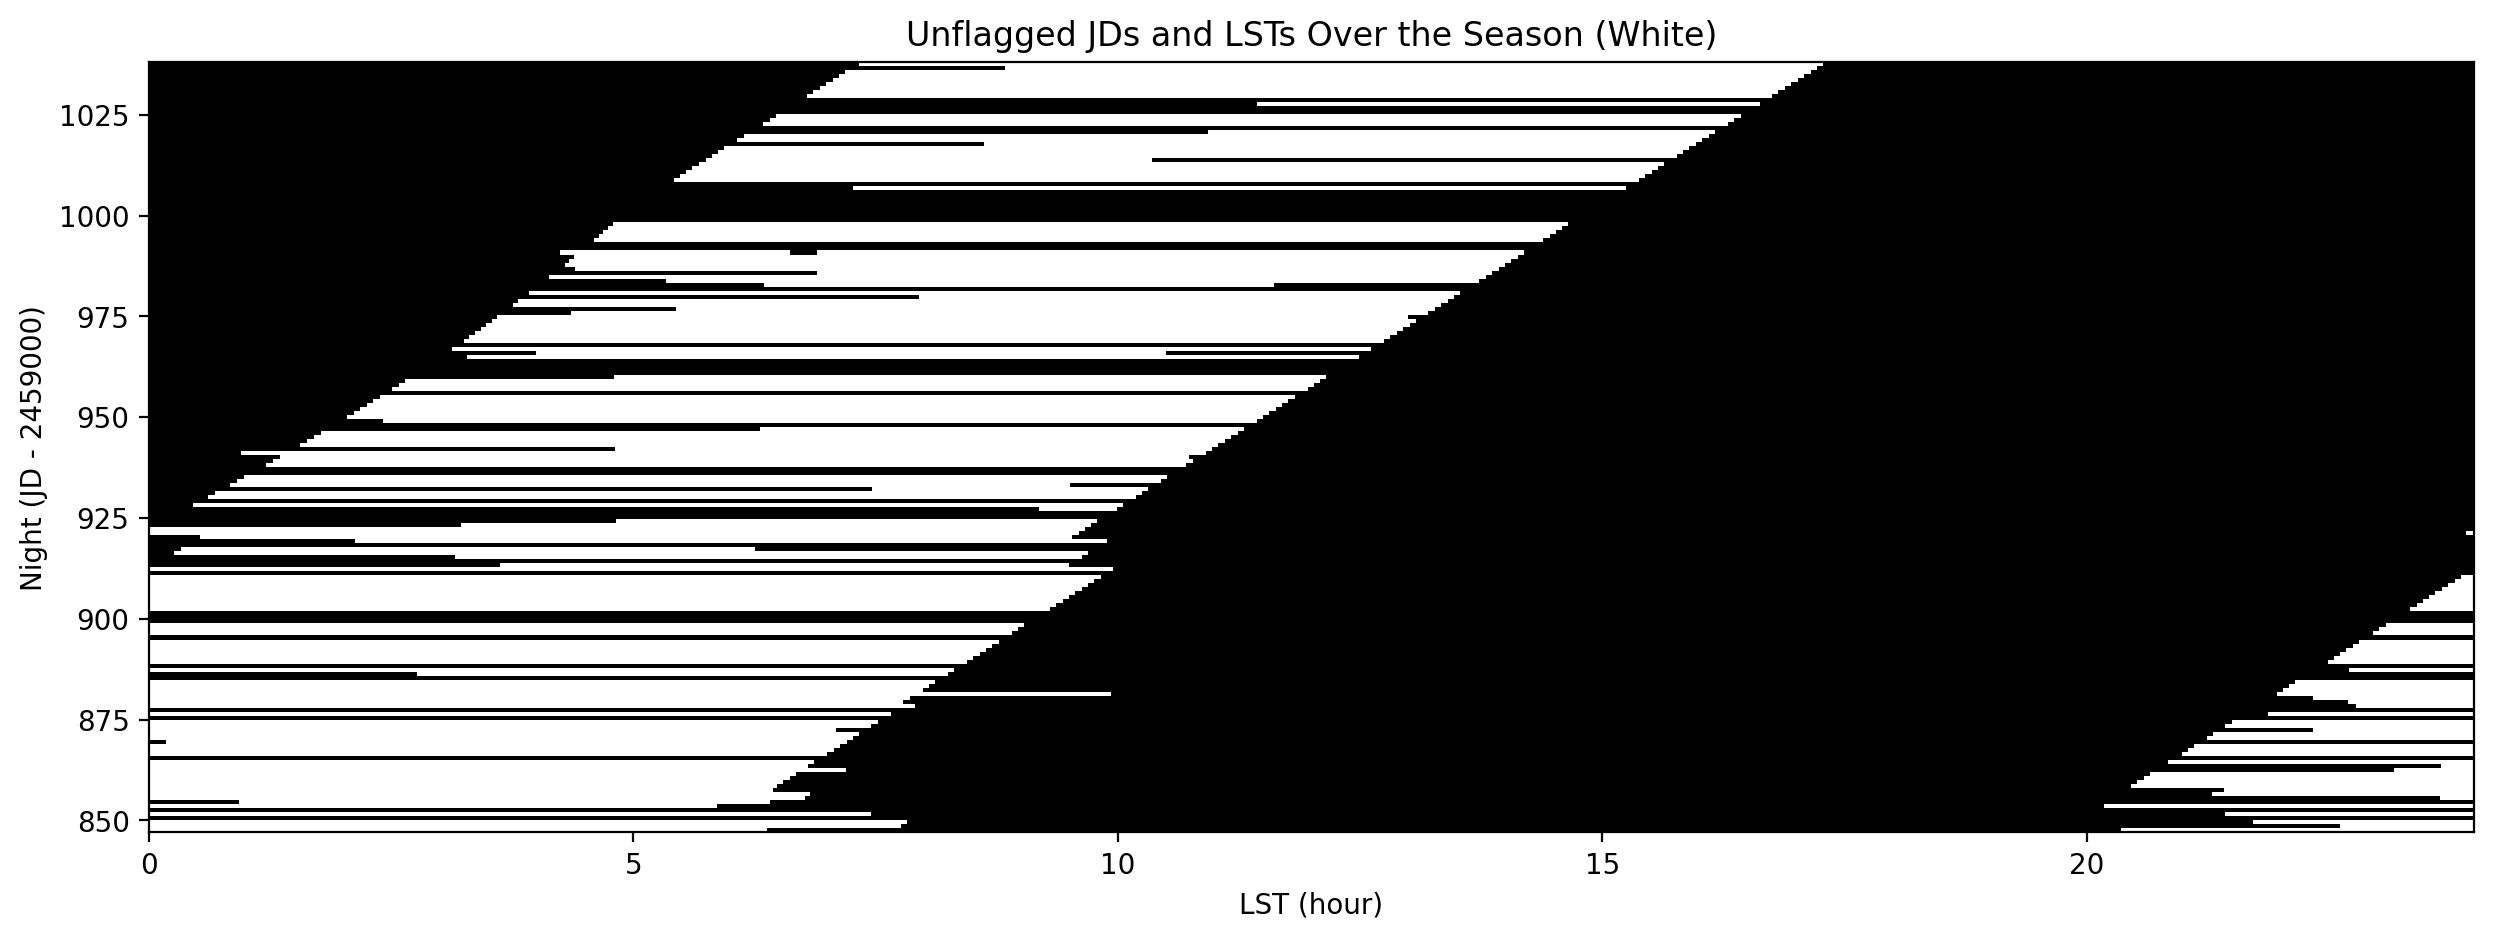

In [14]:
unflagged_LSTs()

In [15]:
def LST_coverage():
    plt.figure(figsize=(15, 5))
    plt.plot(lsts, np.sum(~lst_flag_array, axis=0))
    plt.ylim([0, 1.05 * np.max(np.sum(~lst_flag_array, axis=0))])
    plt.xlim([0, 24])
    plt.grid()
    plt.xlabel("LST (hour)")
    plt.ylabel('Number of Unflagged Nights')

# *Figure 2: LST-Coverage*

This figure shows how often each LST was observed after flagging (subsets of) nights. This represents the maximum number of different nights that could be binned together at a given LST, though additional times may be flagged in the full-pipeline due to, e.g., broadband RFI.

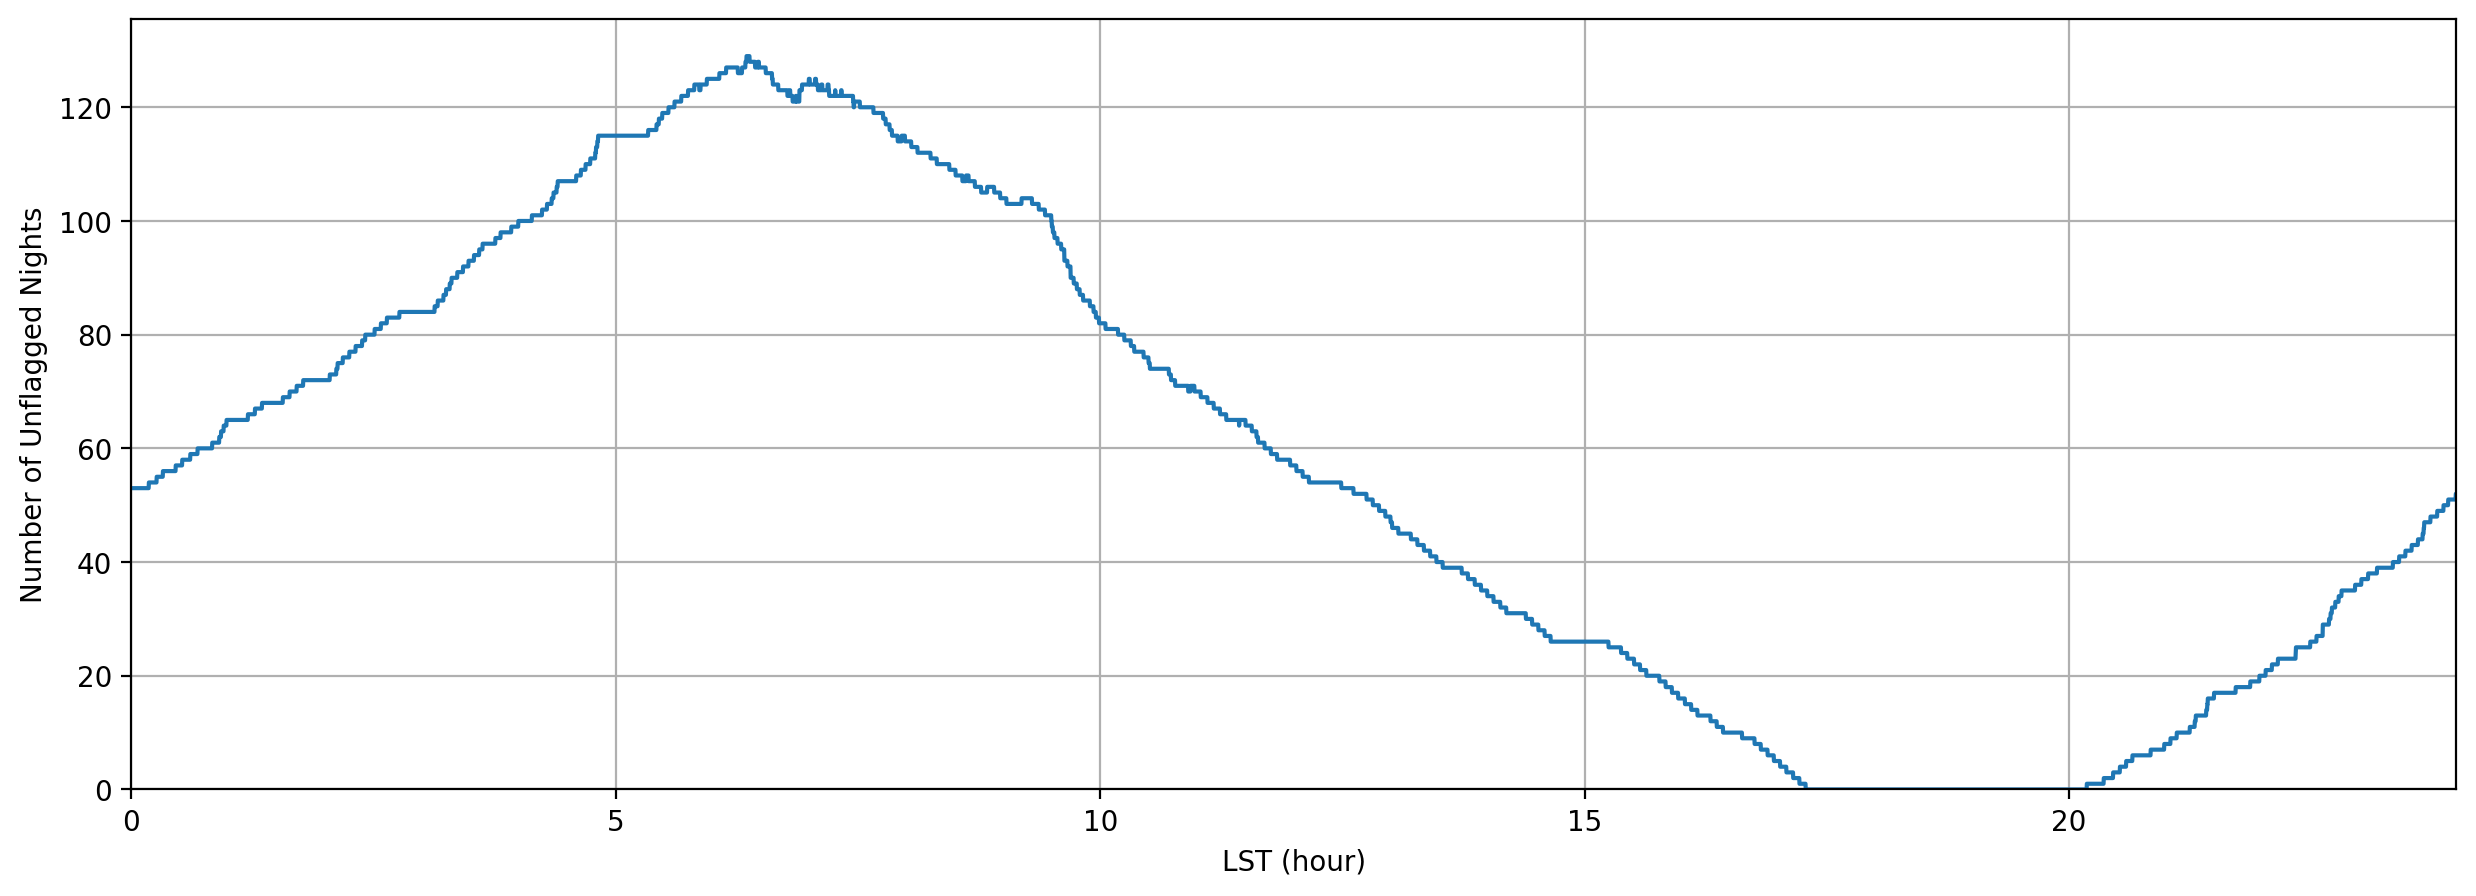

In [16]:
LST_coverage()

## Antenna-Based Flags

These only include antennas that are flagged because of the autocorrelations and flagged for their entire nights.

In [17]:
ngood_ants = {'Jnn': {}, 'Jee': {}}
ntot_ants = {'Jnn': {}, 'Jee': {}}

for pol in ['Jnn', "Jee"]:
    for jd, d in data.items():
        ntot_ants[pol][jd] = len([a for a in d['all_ant'] if a[1] ==pol])
        ngood_ants[pol][jd] = ntot_ants[pol][jd] - len([a for a in d['ex_ants'] if a[1] == pol])

In [18]:
def ant_flag_plot():
    plt.figure(figsize=(15, 5))
    for i, pol in enumerate(ngood_ants):
        if i==1:
            width=-0.4
        else:
            width=0.4
        plt.bar(all_days-2459000, [ngood_ants[pol].get(d, 0) for d in all_days], align='edge', width=width, label=f'Good {pol}')
        plt.bar(all_days-2459000, [ntot_ants[pol].get(d, 0) -  ngood_ants[pol].get(d, 0) for d in all_days], 
                bottom=[ngood_ants[pol].get(d, 0) for d in all_days], align='edge', width=width, label=f'Bad {pol}')
    plt.xlabel("JD - 2459000")
    plt.ylabel("Number of Antennas")
    plt.legend()

# *Figure 3: Number of (Un)Flagged Antennas Per Night*

This plot shows the number of antennas for each polarization that are observed and flagged/unflagged on each night for each polarization. Note that antenna flagging was done only on autocorrelations, so it is likely an undercount because it does not include all flags due to effects that might only show up in the cross-correlations, like node timing issues, packet loss, and non-redundancy. 

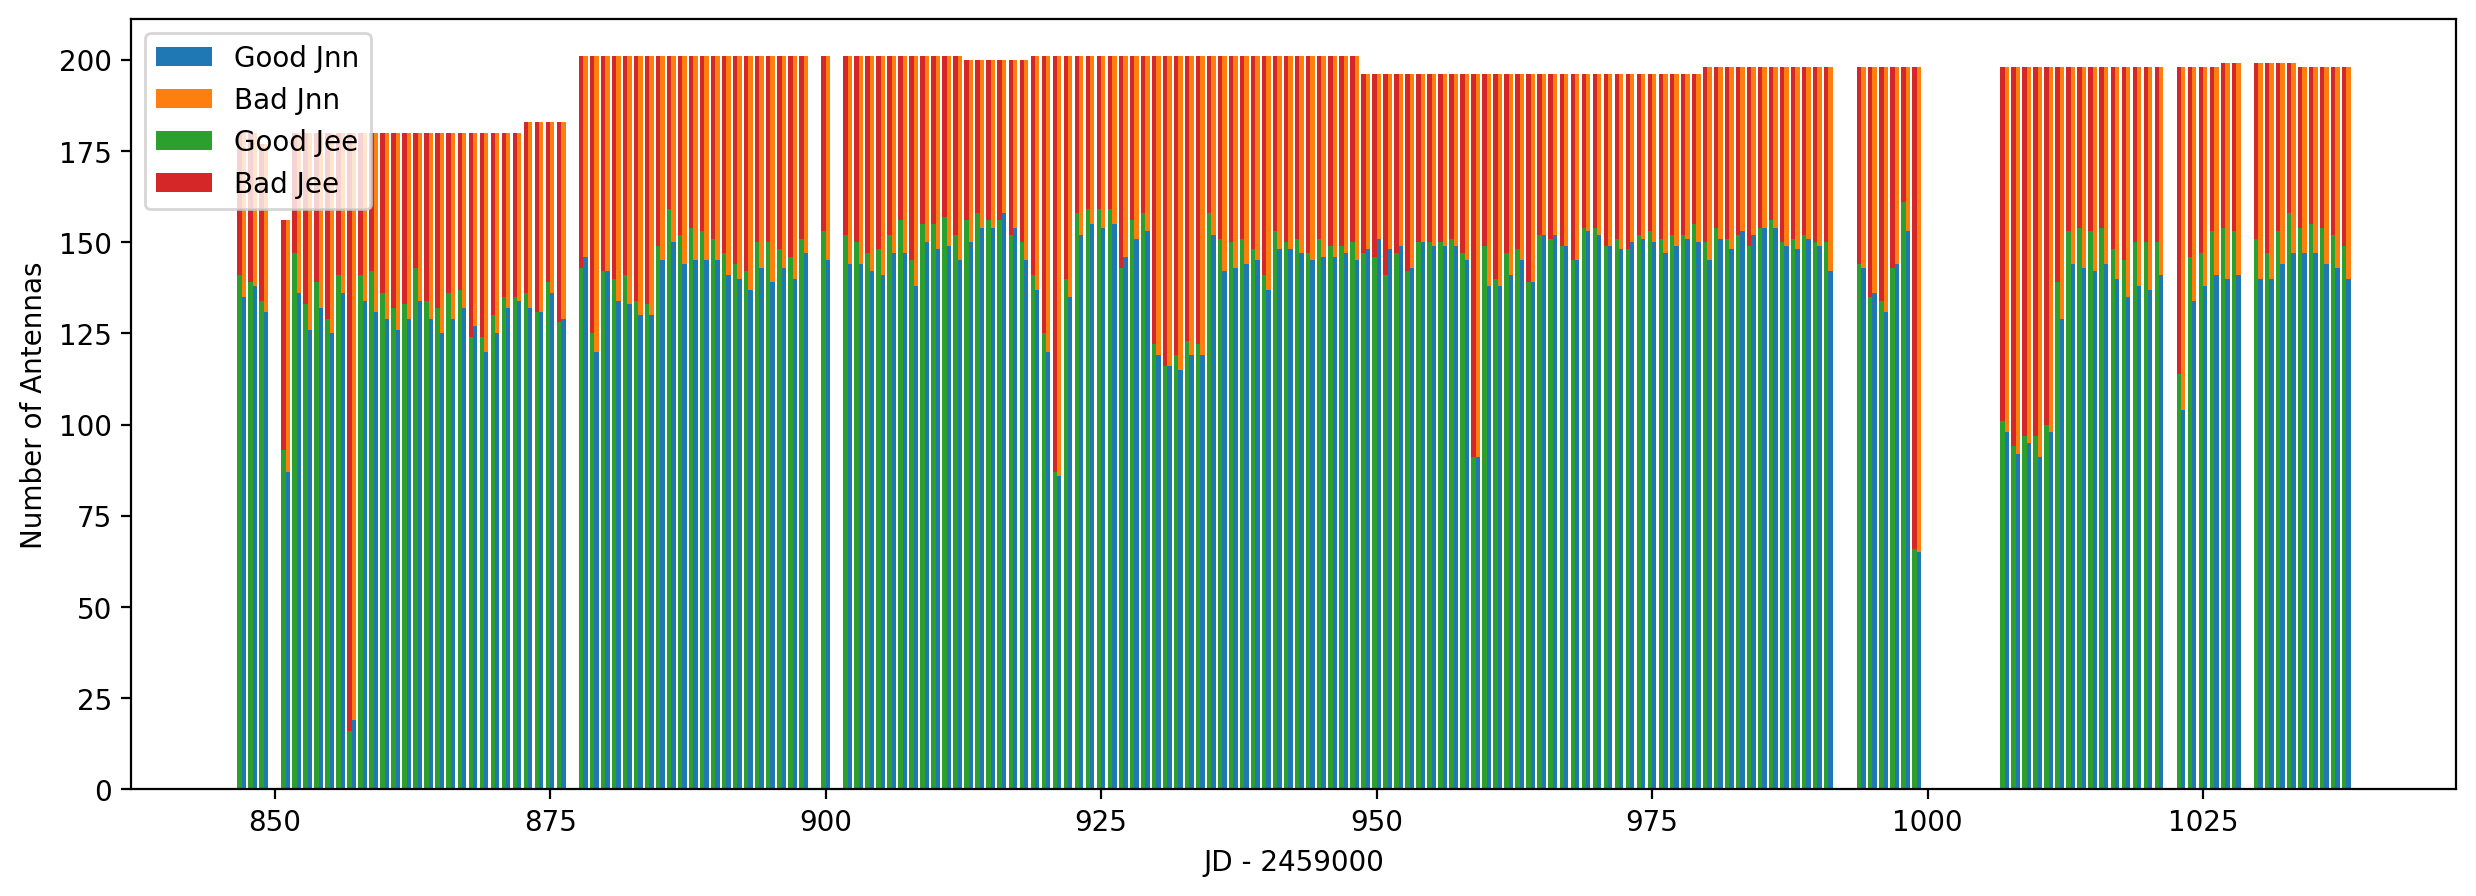

In [19]:
ant_flag_plot()

## Antenna-Time Flags

Times are flagged because of excess broadband structure (e.g. lightning) and because the sun was up.

In [20]:
ngood_ant_hours = {'Jnn': {}, 'Jee': {}}
ntot_ant_hours = {'Jnn': {}, 'Jee': {}}

for pol in ['Jnn', "Jee"]:
    for jd, d in data.items():
        ntot_ant_hours[pol][jd] = ntot_ants[pol][jd] * (d['jd_range'][1] - d['jd_range'][0])*24
        ngood_ant_hours[pol][jd] = ngood_ants[pol][jd] * np.max([0, ((d['jd_range'][1] - d['jd_range'][0])*24 - sum((x[1]- x[0])*24 for x in d['JD_flags']))])

In [21]:
def ant_hour_plot():
    plt.figure(figsize=(15, 5))
    for i, pol in enumerate(ngood_ants):
        if i==1:
            width=-0.4
        else:
            width=0.4
        plt.bar(all_days-2459000, [ngood_ant_hours[pol].get(d, 0) for d in all_days], align='edge', width=width, label=f'Good {pol}')
        plt.bar(all_days-2459000, [ntot_ant_hours[pol].get(d, 0) -  ngood_ant_hours[pol].get(d, 0) for d in all_days], bottom=[ngood_ant_hours[pol].get(d, 0) for d in all_days], align='edge', width=width, label=f'Bad {pol}')
    plt.xlabel("JD - 2459000")
    plt.ylabel("Number of Antenna-Hours")
    plt.legend()

# *Figure 4: Number of (Un)Flagged Antenna-Hours Per Night*

This plot shows the number of antenna-hours for each polarization that are observed and flagged/unflagged on each night for each polarization. Note that antenna flagging was done only on autocorrelations, so it is likely an undercount because it does not include all flags due to effects that might only show up in the cross-correlations, like node timing issues, packet loss, and non-redundancy. Time-flagging includes sun-up data and excess temporal variability (likely due to lightning). Additional times might later be flagged in the full pipeline due to more sporadic broadband RFI.

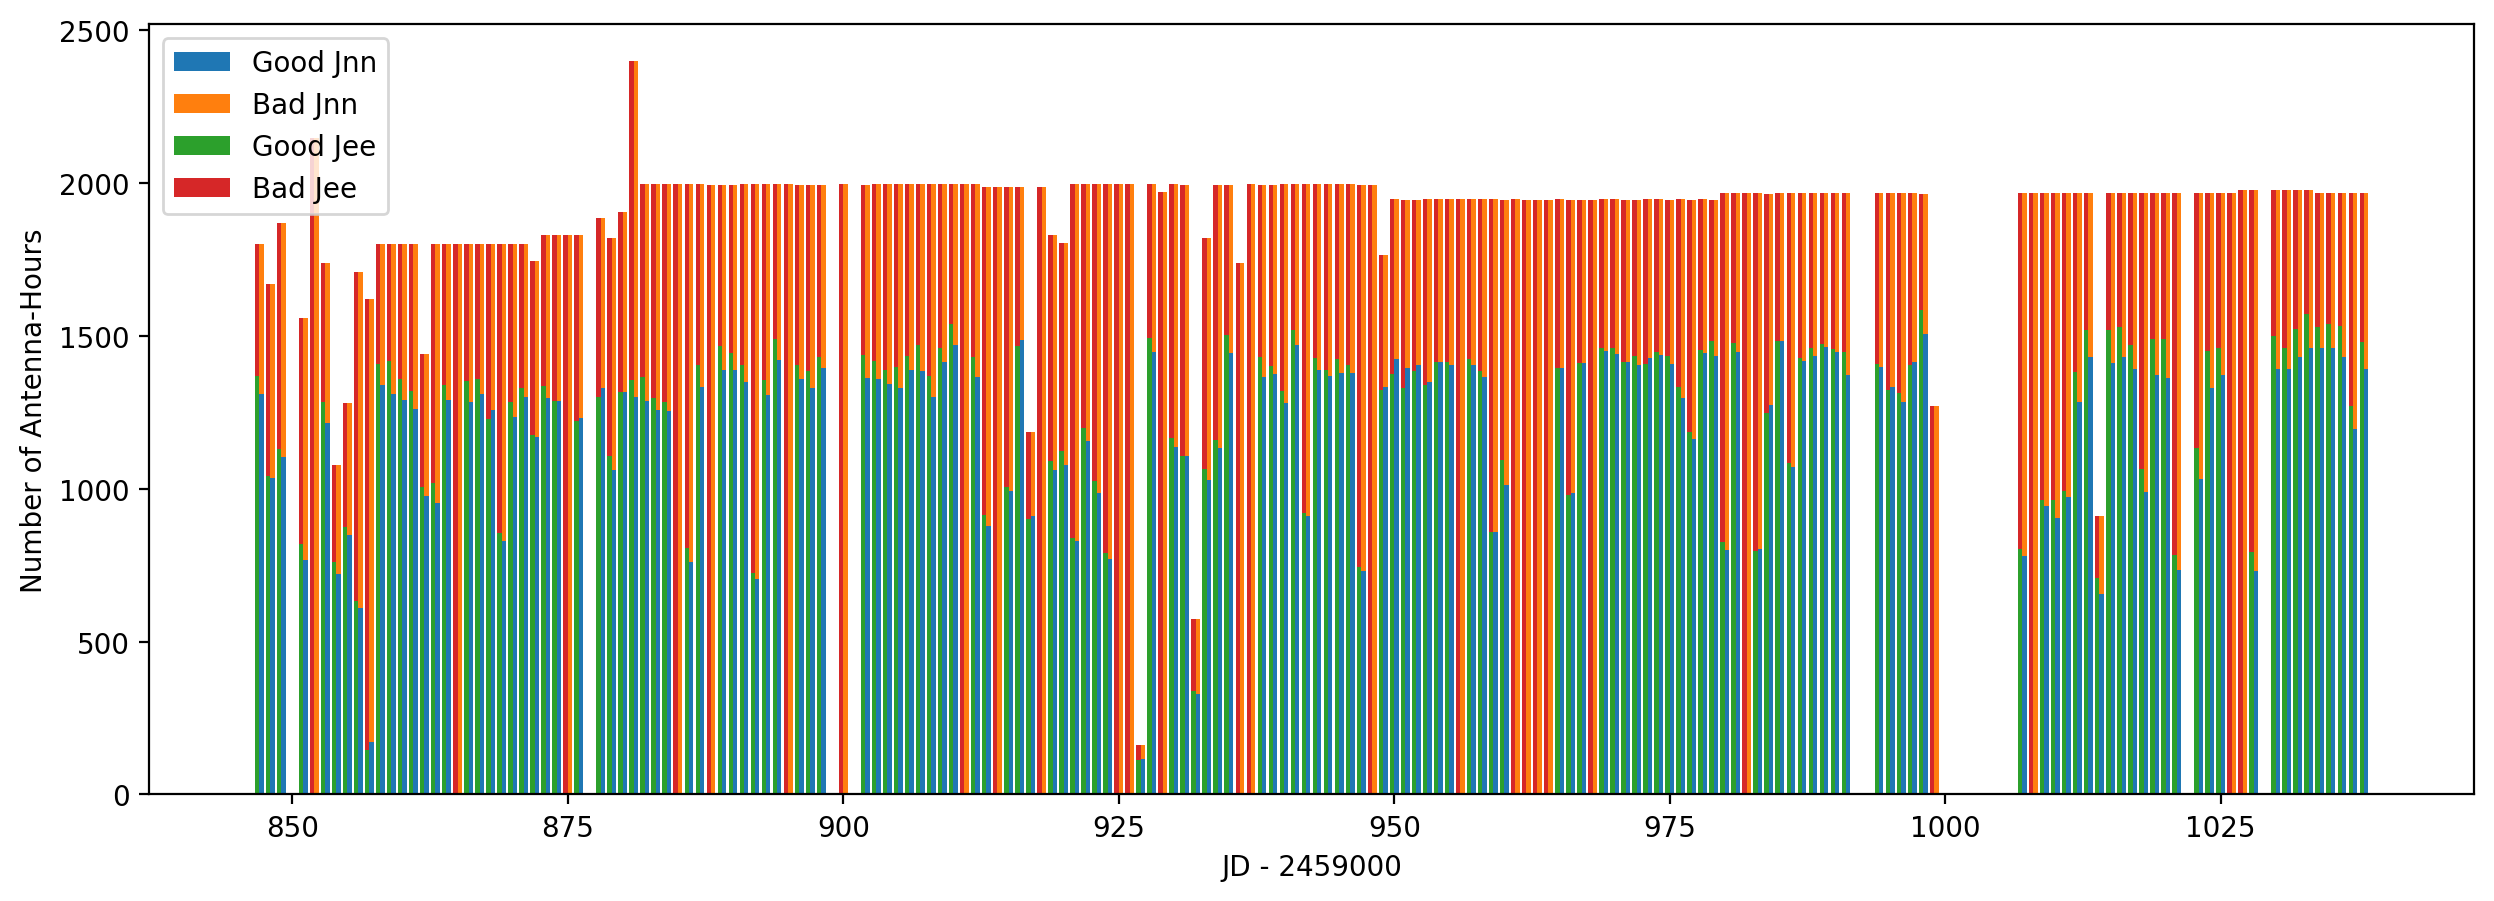

In [22]:
ant_hour_plot()

In [23]:
print(f'Average antenna-hours per observed night (ee): {np.mean(list(ngood_ant_hours["Jee"].values())):.2f}')
print(f'Average antenna-hours per observed night (nn): {np.mean(list(ngood_ant_hours["Jnn"].values())):.2f}')
print(f'Total antenna-hours (ee): {np.sum(list(ngood_ant_hours["Jee"].values())):.2f}')
print(f'Total antenna-hours (nn): {np.sum(list(ngood_ant_hours["Jnn"].values())):.2f}')

Average antenna-hours per observed night (ee): 1062.57
Average antenna-hours per observed night (nn): 1030.03
Total antenna-hours (ee): 188074.95
Total antenna-hours (nn): 182314.75


## Antenna-Time-Frequency Flags

Channels flags are based on narrowband RFI detected in individual 2-integration files. Only channels flagged for an entire night are included here. 87.5 -- 108.0 MHz was flagged a priori due to FM radio contamination.

In [24]:
ngood_ant_hour_chans = {'Jnn': {}, 'Jee': {}}
ntot_ant_hour_chans = {'Jnn': {}, 'Jee': {}}

for pol in ['Jnn', "Jee"]:
    for jd, d in data.items():
        ntot_ant_hour_chans[pol][jd] = ntot_ant_hours[pol][jd] * 1500
        ngood_ant_hour_chans[pol][jd] = ngood_ant_hours[pol][jd] * 1500*((d['freq_range'][1] - d['freq_range'][0]) - sum((x[1]- x[0]) for x in d['freq_flags']))/(d['freq_range'][1] - d['freq_range'][0])

In [25]:
def ant_hour_chan_plot():
    plt.figure(figsize=(15, 5))
    for i, pol in enumerate(ngood_ants):
        if i==1:
            width=-0.4
        else:
            width=0.4
        plt.bar(all_days-2459000, [ngood_ant_hour_chans[pol].get(d, 0) for d in all_days], align='edge', width=width, label=f"Good {pol}")
        plt.bar(all_days-2459000, [ntot_ant_hour_chans[pol].get(d, 0) -  ngood_ant_hour_chans[pol].get(d, 0) for d in all_days], bottom=[ngood_ant_hour_chans[pol].get(d, 0) for d in all_days], align='edge', width=width, label=f"Bad {pol}")
    plt.xlabel("JD - 2459000")
    plt.ylabel("Number of Antenna-Hour-Channels")
    plt.legend()

# *Figure 5: Number of (Un)Flagged Antenna-Hour-Channels Per Night*

This plot shows the number of antenna-hour-channels for each polarization that are observed and flagged/unflagged on each night for each polarization. Note that antenna flagging was done only on autocorrelations, so it is likely an undercount because it does not include all flags due to effects that might only show up in the cross-correlations, like node timing issues, packet loss, and non-redundancy. Time-flagging includes sun-up data and excess temporal variability (likely due to lightning). Additional times might later be flagged in the full pipeline due to more sporadic broadband RFI. Frequency flagging only includes channels that are 100% flagged over the night in quesiton. This includes a handful of channels with persistent emitters, as well as the range from 87.5--108 MHz, the FM band.

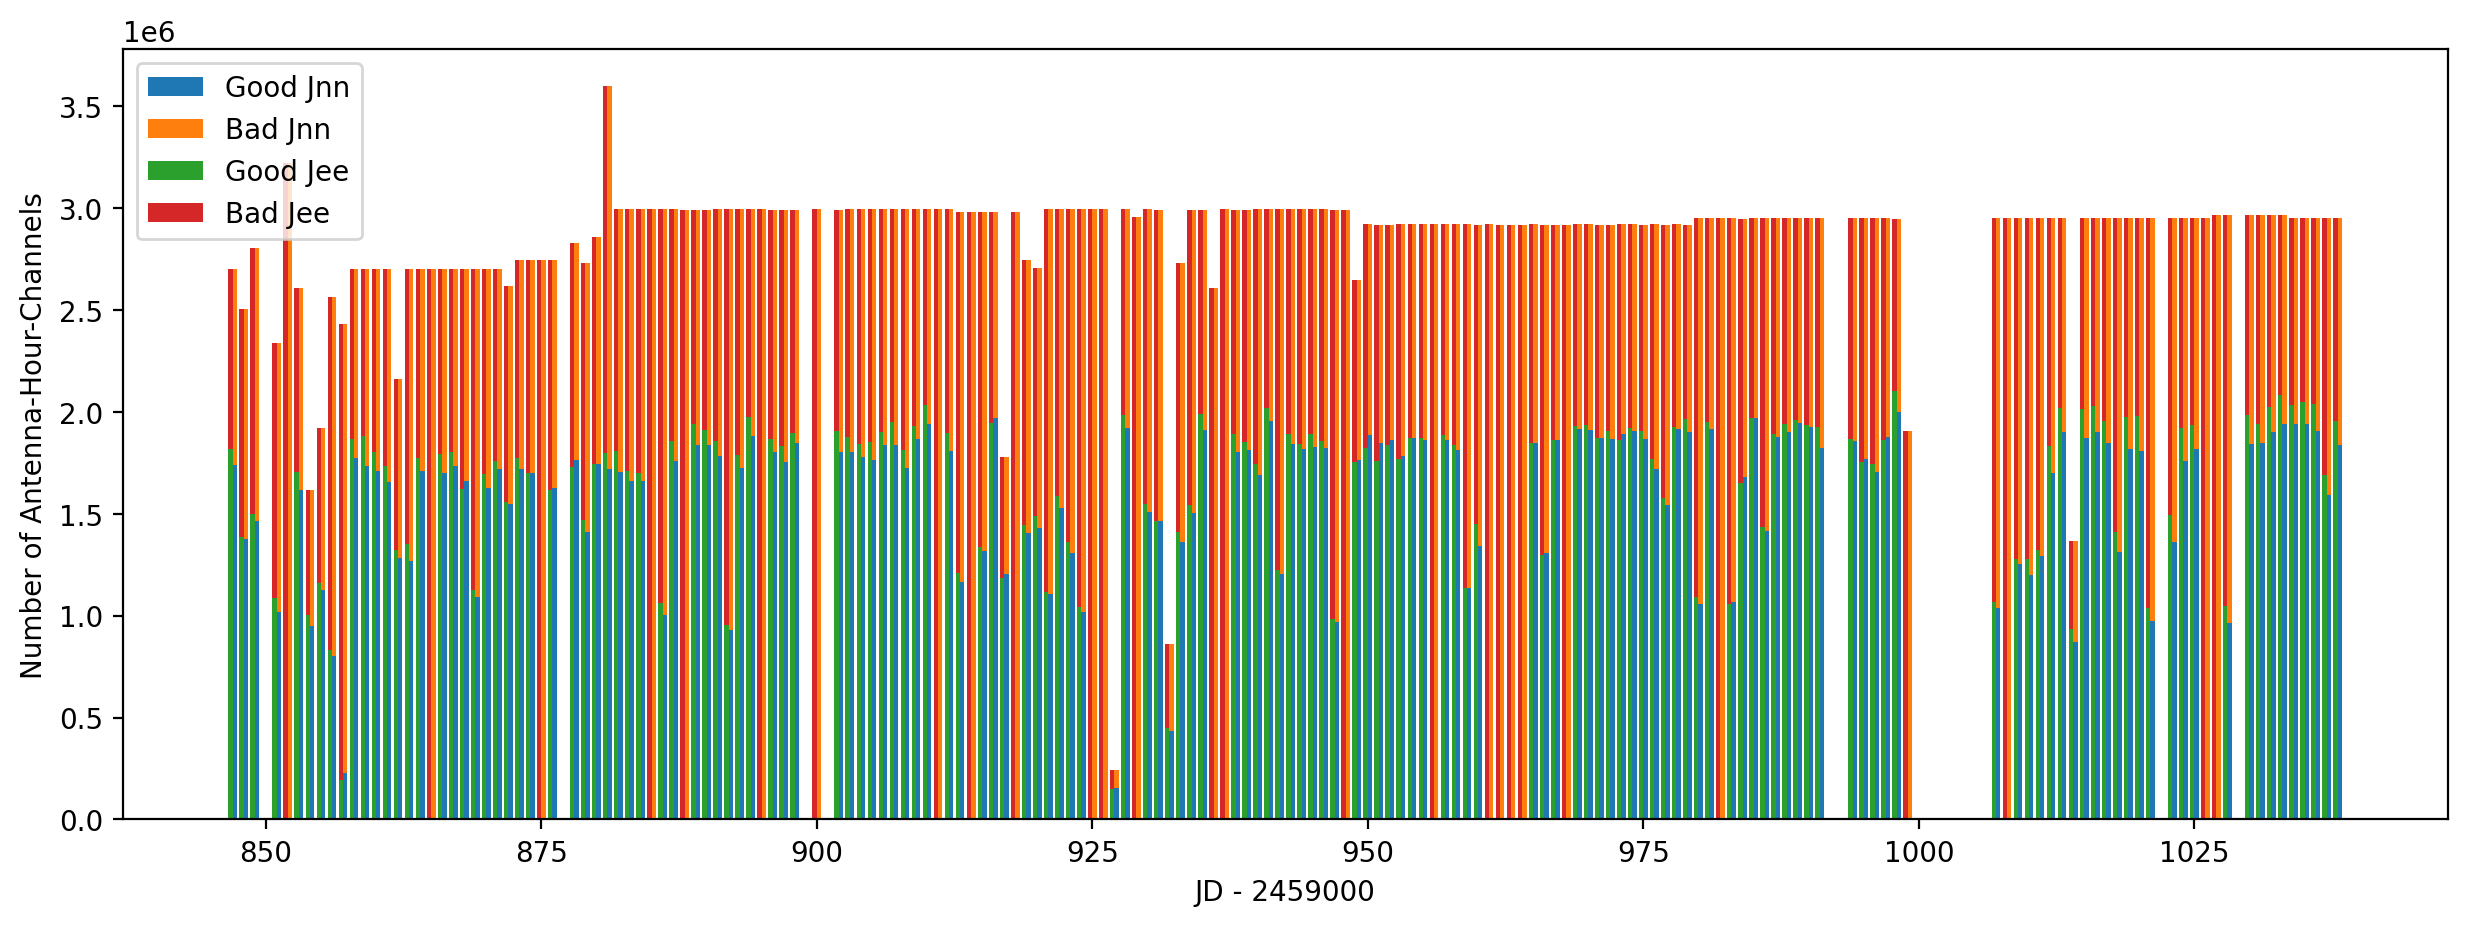

In [26]:
ant_hour_chan_plot()

In [27]:
print(f"Fraction of total possible observed time unflagged (ee): {np.sum(list(ngood_ant_hour_chans['Jee'].values())) / np.sum(list(ntot_ant_hour_chans['Jee'].values())):.2%}")
print(f"Fraction of total possible observed time unflagged (nn): {np.sum(list(ngood_ant_hour_chans['Jnn'].values())) / np.sum(list(ntot_ant_hour_chans['Jnn'].values())):.2%}")

Fraction of total possible observed time unflagged (ee): 49.44%
Fraction of total possible observed time unflagged (nn): 47.92%


## Frequency Flags

In [28]:
fmin, fmax = next(iter(data.values()))['freq_range']
freqs = np.linspace(fmin, fmax, 1500)

freq_flag_array = np.zeros((len(all_days), len(freqs)), dtype=bool)

for i, day in enumerate(all_days):
    if day not in data:
        freq_flag_array[i] = True
    else:
        for flgs in data[day]['freq_flags']:
            freq_flag_array[i][(freqs >= flgs[0]) & (freqs < flgs[1])] = True

In [29]:
def channel_flag_plot():
    plt.figure(figsize=(15, 5))
    plt.imshow(~freq_flag_array, aspect='auto', interpolation='none', origin='lower', cmap='binary_r',
               extent=(freqs.min()/1e6, freqs.max()/1e6, min(all_days)-2459000, max(all_days)-2459000))
    plt.xlabel("Frequency (MHz)")
    plt.ylabel("JD - 2459000")
    plt.title("Completely Flagged Channels Over Nights");

# *Figure 6: Completely Flagged Channels By Night*

This plot shows which channels are flagged in every file on any given night--channels that are only sometimes (or even often) flagged might become fully-flagged in later processing when we attempt to make a self-consistent flagging mask for a whole night. The most prominent feature here is the FM band, which is flagged a priori from 87.5--108 MHz due to the difficulty of identifying low-level RFI amongst extremely bright RFI.

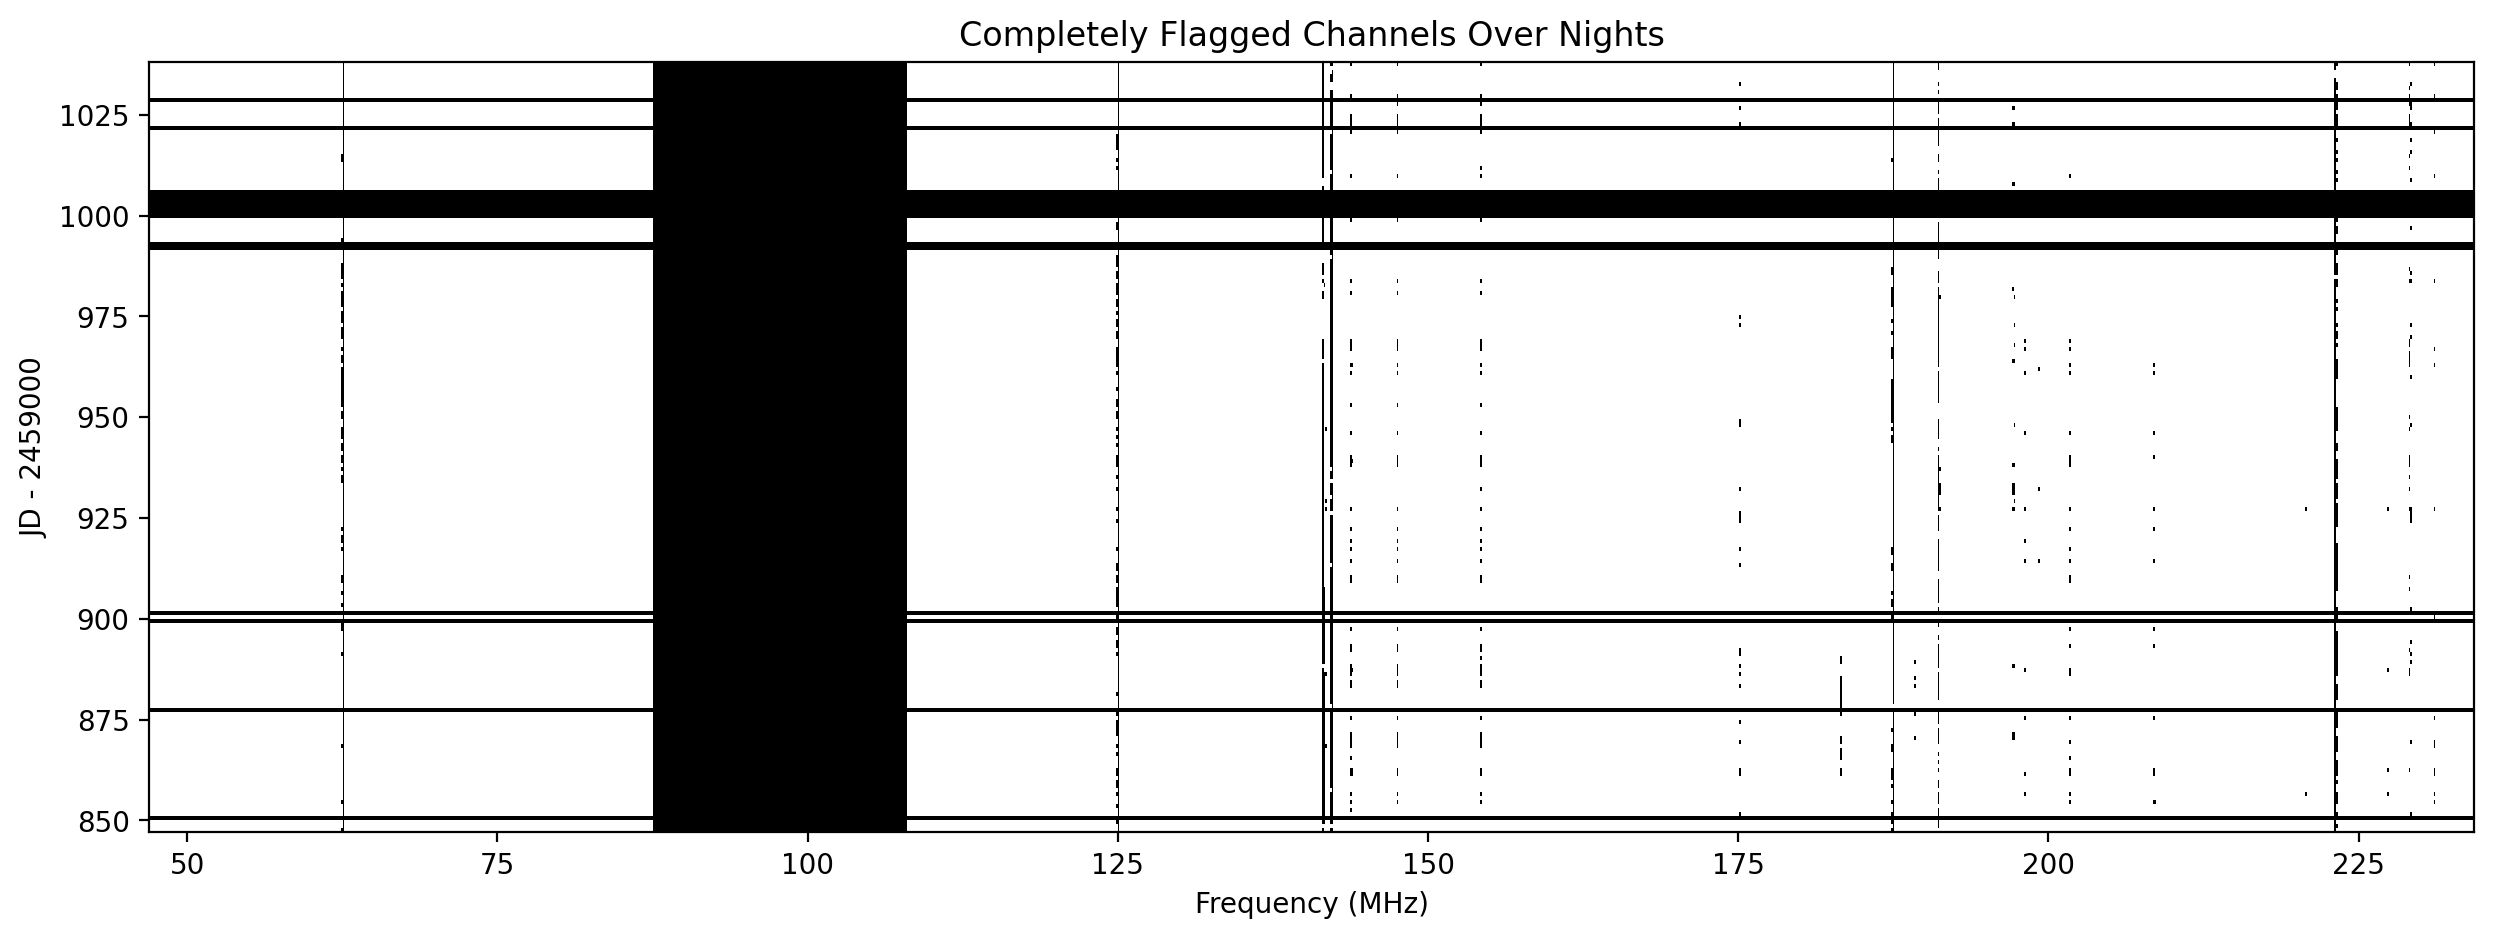

In [30]:
channel_flag_plot()

## Cutoff Parameters for Excluding Nights

These parameters help us make the decision about whether a night is worth analyzing. If the amount of unflagged data is too small, it is easier to simply give up on the day and move on.

In [31]:
min_unflagged_hours = 4
min_unflagged_antpols_frac = .4
min_unflagged_antpolhours_frac = .3

## Nightly Summary Table

In [32]:
jd_col = list(range(min(all_days), max(all_days) + 1))

hours_obs = []
unflagged_hours = []
unflagged_time_frac = []
antpols_obs = []
unflagged_antpols = []
unflagged_antpols_frac = []
unflagged_antpol_hours = []
unflagged_antpolhours_frac = []
night_flagged = []

sum_unflagged_nights = 0
sum_unflagged_hours = 0
sum_unflagged_antpol_hours = 0
sum_unflagged_antpolsq_hours = 0

for JD in jd_col:
    if JD in data:
        hrs_obs = (data[JD]['jd_range'][1] - data[JD]['jd_range'][0]) * 24
        hrs_flagged = np.sum([np.diff(f) for f in data[JD]['JD_flags']]) * 24
        hours_obs.append(f"{hrs_obs:.2f}")
        unflagged_hours.append(f"{np.max([hrs_obs - hrs_flagged, 0]):.2f}")
        unflagged_time_frac.append(f"{np.max([hrs_obs - hrs_flagged, 0]) / hrs_obs:.1%}")
        
        ap_obs = len(data[JD]['all_ant'])
        ap_flagged = len(data[JD]['ex_ants'])
        antpols_obs.append(f"{ap_obs}")
        unflagged_antpols.append(f"{ap_obs - ap_flagged}")
        unflagged_antpols_frac.append(f"{(ap_obs - ap_flagged) / ap_obs:.1%}")
        unflagged_antpol_hours.append(f"{np.max([hrs_obs - hrs_flagged, 0]) * (ap_obs - ap_flagged):.1f}")
        unflagged_antpolhours_frac.append(f"{np.max([hrs_obs - hrs_flagged, 0]) * (ap_obs - ap_flagged) / hrs_obs / ap_obs:.1%}")
        
        is_flagged = (hrs_obs - hrs_flagged) < min_unflagged_hours
        is_flagged |= ((ap_obs - ap_flagged) / ap_obs) < min_unflagged_antpols_frac
        is_flagged |= ((hrs_obs - hrs_flagged) * (ap_obs - ap_flagged) / hrs_obs / ap_obs) < min_unflagged_antpolhours_frac
        night_flagged.append(is_flagged)
        
        sum_unflagged_nights += float(~is_flagged)
        sum_unflagged_hours += float(~is_flagged) * np.max([hrs_obs - hrs_flagged, 0])
        sum_unflagged_antpol_hours += float(~is_flagged) * np.max([hrs_obs - hrs_flagged, 0]) * (ap_obs - ap_flagged)
        sum_unflagged_antpolsq_hours += float(~is_flagged) * np.max([hrs_obs - hrs_flagged, 0]) * (ap_obs - ap_flagged)**2
        
    else:
        for arr in [hours_obs, unflagged_hours, unflagged_time_frac, antpols_obs, unflagged_antpols,
                    unflagged_antpols_frac, unflagged_antpol_hours, unflagged_antpolhours_frac]:
            arr.append('-')
        night_flagged.append(True)

df = pd.DataFrame({'JD': jd_col, 
                   'Hours Observed': hours_obs, 
                   'Unflagged Hours': unflagged_hours,
                   'Unflagged Time %': unflagged_time_frac,
                   'Antpols in Data': antpols_obs,
                   'Unflagged Antpols': unflagged_antpols,
                   'Unflagged Antpol %': unflagged_antpols_frac,
                   'Unflagged Antpol-Hours': unflagged_antpol_hours,
                   'Unflagged Antpol-Time %': unflagged_antpolhours_frac,
                  })

# background_gradient(cmap='viridis', vmax=mean_round_modz_cut * 3, vmin=0, axis=None, subset=z_score_cols) \

utp_vals = [float(entry[:-1]) if entry != '-' else 0 for entry in df['Unflagged Time %']]
uap_vals = [float(entry[:-1]) if entry != '-' else 0 for entry in df['Unflagged Antpol %']]
uatp_vals = [float(entry[:-1]) if entry != '-' else 0 for entry in df['Unflagged Antpol-Time %']]
table = df.style.hide().background_gradient(subset=['Unflagged Time %'], cmap='RdYlGn', gmap=utp_vals) \
                       .background_gradient(subset=['Unflagged Antpol %'], cmap='RdYlGn', gmap=uap_vals) \
                       .background_gradient(subset=['Unflagged Antpol-Time %'], cmap='RdYlGn', gmap=uatp_vals) \
                       .background_gradient(subset=['JD'], cmap='RdYlGn_r', gmap=night_flagged) \
                       .set_table_styles([dict(selector="th",props=[('max-width', f'60pt')])])

# *Table 1: Per-Night Scouting Summary*

This table summarizes the per night statistics for the amount of data, unflagged data, and flagging fractions along various axes. Note that the level of flagging is likely an underestimate, since this initial data investigation was done using only autocorrelations and it might be missing some flags that the full pipeline would find. Nights with dashes instead of data were not observed. JDs in green are likely worth analyzing; JDs in red are likely not. 

In [33]:
HTML(table.to_html())

JD,Hours Observed,Unflagged Hours,Unflagged Time %,Antpols in Data,Unflagged Antpols,Unflagged Antpol %,Unflagged Antpol-Hours,Unflagged Antpol-Time %
2459847,9.99,9.71,97.1%,360,276,76.7%,2679.0,74.5%
2459848,9.27,7.50,80.9%,360,277,76.9%,2077.3,62.2%
2459849,10.55,8.44,80.0%,354,265,74.9%,2235.7,59.9%
2459850,-,-,-,-,-,-,-,-
2459851,9.99,8.82,88.3%,312,180,57.7%,1587.7,50.9%
2459852,11.93,0.00,0.0%,360,283,78.6%,0.0,0.0%
2459853,9.65,9.65,100.0%,360,259,71.9%,2499.6,71.9%
2459854,5.99,5.47,91.2%,360,271,75.3%,1481.1,68.6%
2459855,7.11,6.78,95.4%,360,254,70.6%,1722.9,67.3%
2459856,9.50,4.48,47.1%,360,277,76.9%,1240.6,36.3%


# *Table 2: Bottom-Line Summary*

In [34]:
print(f'• H6C has (up to) {sum_unflagged_nights:.0f} nights worth analyzing out of {len(yamls)} nights of data in the season.')
print(f'• H6C has (up to) a combined {sum_unflagged_hours:.1f} hours of data worth analyzing.')
print(f'• Those nights have (up to) an average of {sum_unflagged_antpol_hours / sum_unflagged_hours:.1f} unflagged antpols.')
print(f'• H6C has (up to) a combined {sum_unflagged_antpol_hours:.2e} antpol-hours of data worth analyzing.')
print(f'• H6C has (up to) a combined {sum_unflagged_antpolsq_hours:.2e} antpol^2-hours of data worth analyzing.')
print(f'• The nights worth analyzing are:\n{[jd for jd, nf in zip(jd_col, night_flagged) if not nf]}')

• H6C has (up to) 147 nights worth analyzing out of 177 nights of data in the season.
• H6C has (up to) a combined 1312.2 hours of data worth analyzing.
• Those nights have (up to) an average of 281.3 unflagged antpols.
• H6C has (up to) a combined 3.69e+05 antpol-hours of data worth analyzing.
• H6C has (up to) a combined 1.05e+08 antpol^2-hours of data worth analyzing.
• The nights worth analyzing are:
[2459847, 2459848, 2459849, 2459851, 2459853, 2459854, 2459855, 2459856, 2459858, 2459859, 2459860, 2459861, 2459862, 2459863, 2459864, 2459866, 2459867, 2459868, 2459869, 2459870, 2459871, 2459872, 2459873, 2459874, 2459876, 2459878, 2459879, 2459880, 2459881, 2459882, 2459883, 2459884, 2459886, 2459887, 2459889, 2459890, 2459891, 2459892, 2459893, 2459894, 2459896, 2459897, 2459898, 2459902, 2459903, 2459904, 2459905, 2459906, 2459907, 2459908, 2459909, 2459910, 2459912, 2459913, 2459915, 2459916, 2459917, 2459919, 2459920, 2459921, 2459922, 2459923, 2459924, 2459928, 2459930, 245993